## Abstract

In this blog post, I extend the logistic regression method so we can understand overftting through an over paramatized linear regression. I test them on a synthetic dataset to explore how well they perform binary classification tasks as well as a dataset that generates a corrupted image of the flower. The goal is to better understand how these models actually work under the hood and compare their decision boundaries and overall accuracy and see what number of features is the best to use to prevent overfitting. 

In [23]:
%load_ext autoreload
%autoreload 2
from logistic import MyLinearRegression, OverParameterizedLinearRegressionOptimizer, RandomFeatures

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Part 0

When p>n, X^TX is a pXp matrix, but it is rank deficent because x only has n rows, so the matrix X can not span all of R^p. Therefore, X^TX is not invertible.

## Part A: Implement Overparameterized Linear Regression

NameError: name 'X_train' is not defined

## Part B: Test Your Model on Simple Data

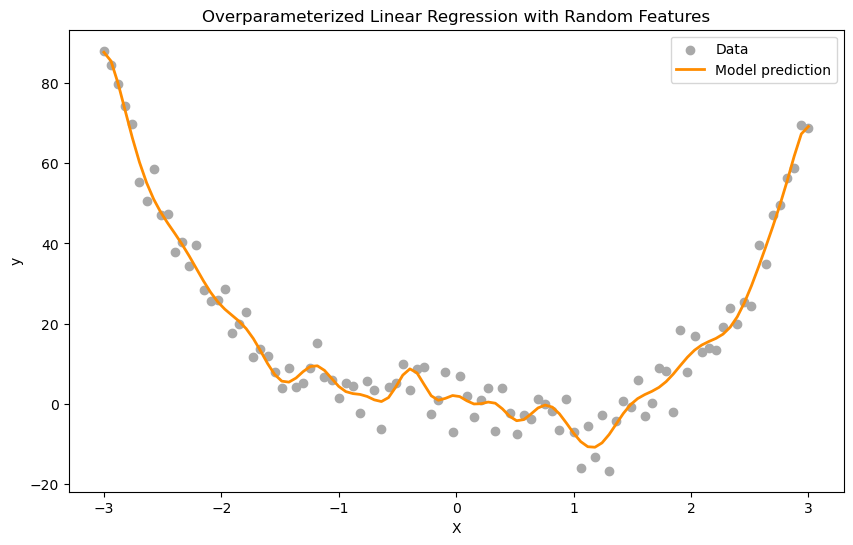

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np

import numpy as np
import torch
import matplotlib.pyplot as plt

#Simulate nonlinear data
X = torch.tensor(np.linspace(-3, 3, 100).reshape(-1, 1), dtype=torch.float64)
y = X**4 - 4*X + torch.normal(0, 5, size=X.shape)

#Create and fit RandomFeatures using created method
phi = RandomFeatures(n_features=500)
phi.fit(X)
X_features = phi.transform(X)

#Fit model
model = MyLinearRegression()
optimizer = OverParameterizedLinearRegressionOptimizer(model)
optimizer.fit(X_features, y)

# predict
y_pred = model.predict(X_features).detach()

#Plot predictions vs. true data
plt.figure(figsize=(10, 6))
plt.scatter(X.numpy(), y.numpy(), color='darkgrey', label='Data')
plt.plot(X.numpy(), y_pred.numpy(), color='darkorange', label='Model prediction', linewidth=2)
plt.title("Overparameterized Linear Regression with Random Features")
plt.xlabel("X")
plt.ylabel("y")
plt.legend()
plt.show()



Here, we can see overfitting takes place based on how well the line follows the data. We can assume that these are just quirks/natural variations in the training data, and that the testing data wouldn't be similar. Therefore, the data is overfit.

## Part C: Double Descent In Image Corruption Detection

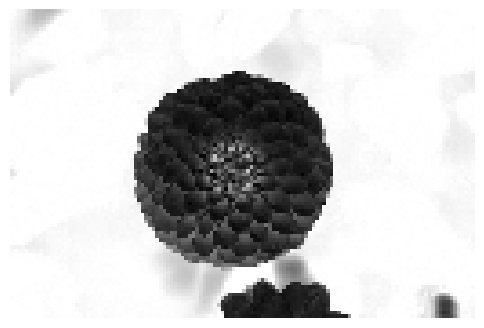

In [25]:
from sklearn.datasets import load_sample_images
from scipy.ndimage import zoom

dataset = load_sample_images()     
X = dataset.images[1]
X = zoom(X,.2) #decimate resolution
X = X.sum(axis = 2)
X = X.max() - X 
X = X / X.max()
flower = torch.tensor(X, dtype = torch.float64)

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(flower, cmap = "gray")
off = ax.axis("off")

In [26]:
def corrupted_image(im, mean_patches = 5): 
    n_pixels = im.size()
    num_pixels_to_corrupt = torch.round(mean_patches*torch.rand(1))
    num_added = 0

    X = im.clone()

    for _ in torch.arange(num_pixels_to_corrupt.item()): 
        
        try: 
            x = torch.randint(0, n_pixels[0], (2,))

            x = torch.randint(0, n_pixels[0], (1,))
            y = torch.randint(0, n_pixels[1], (1,))

            s = torch.randint(5, 10, (1,))
            
            patch = torch.zeros((s.item(), s.item()), dtype = torch.float64) + 0.5

            # place patch in base image X
            X[x:x+s.item(), y:y+s.item()] = patch
            num_added += 1

            
        except: 
            pass

    return X, num_added

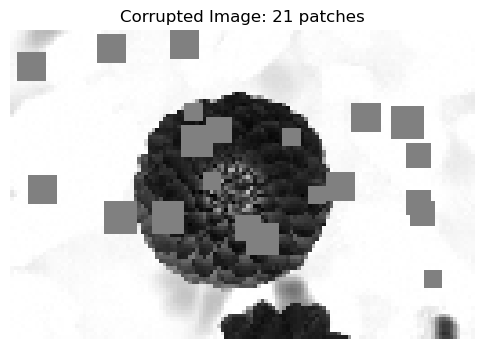

In [29]:
X, y = corrupted_image(flower, mean_patches = 50)
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(X.numpy(), vmin = 0, vmax = 1, cmap= "gray")
ax.set(title = f"Corrupted Image: {y} patches")
off = plt.gca().axis("off")

def square(x): 
    return x ** 2

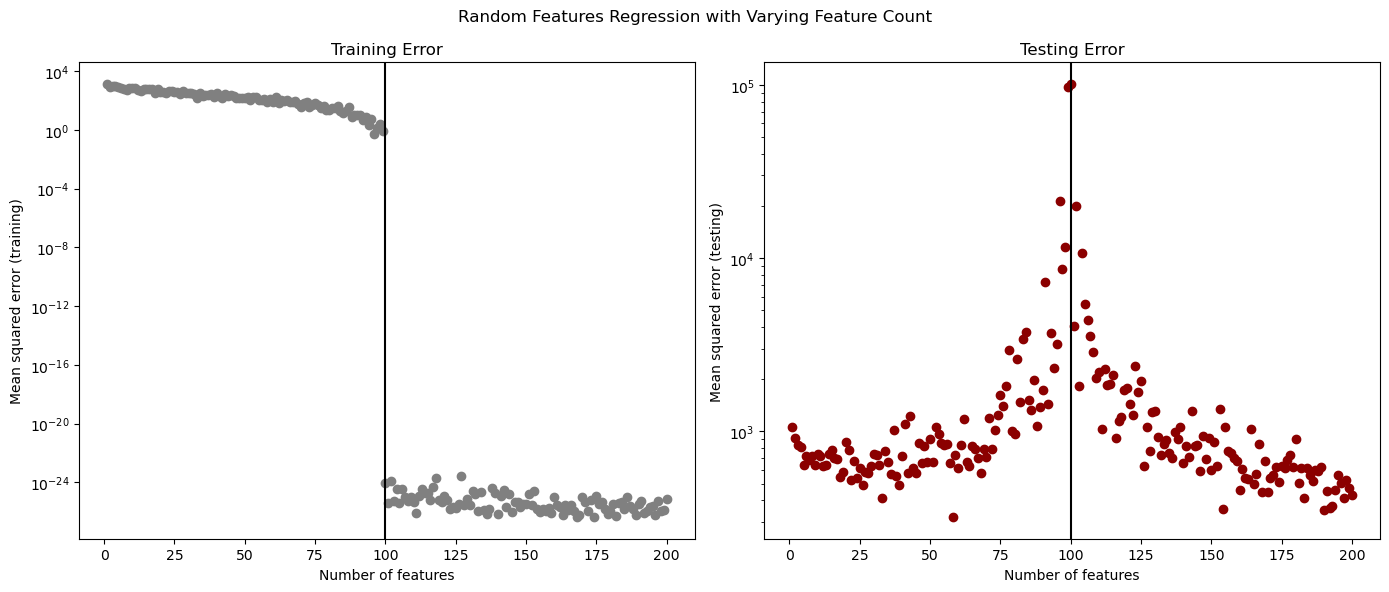

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
n_samples = 200

X = torch.zeros((n_samples, flower.size()[0], flower.size()[1]), dtype = torch.float64) #creating x and y vectors
y = torch.zeros(n_samples, dtype = torch.float64)
for i in range(n_samples): 
    X[i], y[i] = corrupted_image(flower, mean_patches = 100)

X = X.reshape(n_samples, -1)
# X.reshape(n_samples, -1).size()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42) #splitting data

# Initalizing number of features and error counts
feature_sizes = range(1, 201)
train_errors = []
test_errors = []

#interpolation threshold line
interpolation_threshold = X_train.shape[0]

for n_features in feature_sizes:
    #Creating and fit random features
    phi = RandomFeatures(n_features =n_features, activation=  square)
    phi.fit(X_train)

    X_train_phi = phi.transform(X_train)
    X_test_phi = phi.transform(X_test)

    #Fit model
    model = MyLinearRegression()
    optimizer = OverParameterizedLinearRegressionOptimizer(model)
    optimizer.fit(X_train_phi,  y_train)

    #Predict/Compute errors for both datasets
    y_train_pred = model.predict(X_train_phi).detach()
    y_test_pred = model.predict(X_test_phi).detach()

    #Computing MSE of both datasets
    train_mse = mean_squared_error(y_train.numpy(), y_train_pred.numpy())
    test_mse = mean_squared_error(y_test.numpy(), y_test_pred.numpy())

    #adding them to lists t plot
    train_errors.append(train_mse)
    test_errors.append(test_mse)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

#Plot Training Error
ax1.plot(feature_sizes, train_errors, 'o', color='gray')
ax1.set_yscale('log')
ax1.set_xlabel("Number of features")
ax1.set_ylabel("Mean squared error (training)")
ax1.axvline(interpolation_threshold, color='black')
ax1.set_title("Training Error")

#Plot Testing Error
ax2.plot(feature_sizes, test_errors, 'o', color='darkred')
ax2.set_yscale('log')
ax2.set_xlabel("Number of  features")
ax2.set_ylabel("Mean squared error (testing)")
ax2.axvline(interpolation_threshold, color='black')
ax2.set_title("Testing Error")

plt.suptitle("Random Features Regression with Varing Feature Count")
plt.tight_layout()
plt.show()


In [32]:
best_n_features = feature_sizes[np.argmin(test_errors)]
print(f"Best number of features: {best_n_features}")
print("Above threshold" if best_n_features> interpolation_threshold else "Below threshold")

Best number of features: 58
Below threshold


I recieved the smallest error when it was below the interpretation threshold, at 58 features. This makes sense, as it prevents overfitting. 

## Part D: Discussion

Through this blog post, I implement more classes in the my logistic regression so we can analyze overfitting and double descent. Double descent helps us find the sweet spot by adding features and then optimizing to find the ideal number of features as to not prevent overfitting. We see this by examining the graph in part C, where we find the ideal number of features, which is below the interpretation threshold.